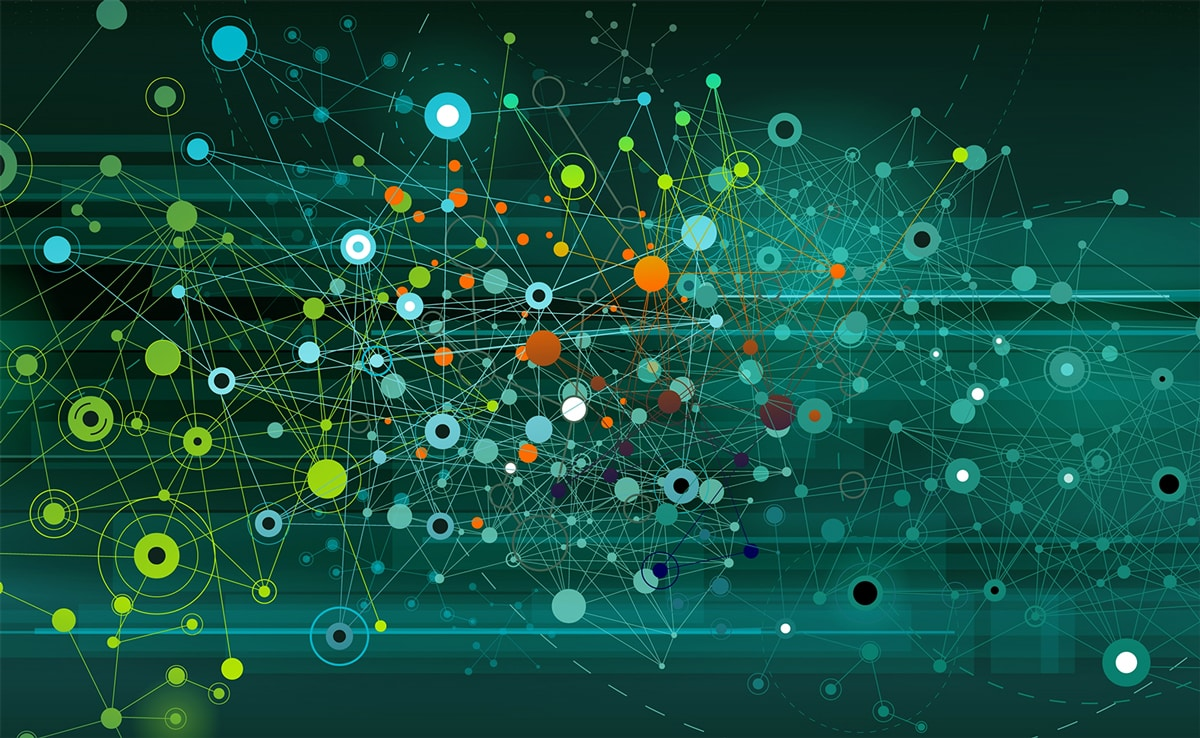
# Livrable 1

## Classification binaire

### Groupe de projet :
- Rémi Papin
- Fabien Richard
- Zacharia Azzouzi
<br>
<br>

### Introduction

Dans un premier temps, ce premier livrable consiste en la réalisation d'un classificateur binaire. Ce classificateur à pour role de séparé les datasets fournis en deux groupe, un groupe "photo" et un groupe "pas photo" :
- Photo
- Painting
- Schematics
- Sketch
- Texte



#### Import

L'ensemble des imports des bibliothèques pour mener à bien ce projet.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import configuration
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import datetime
from tensorboard.plugins.hparams import api as hp
%matplotlib inline

In [3]:
import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# dataset_url = "G:\EXIA\A5\Data-science\Projet-Leyenda\Datasets"

# data_dir = tf.keras.utils.get_file('Photo', origin=dataset_url, extract=True)
# data_dir = pathlib.Path(data_dir)
image_h = 180
image_w = 180
batch_s = 32

data_dir = configuration.data_dir
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  validation_split= 0.8, 
  subset = "training",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)

# Le test_set
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels = "inferred",
  validation_split= 0.2,
  subset = "validation",
  seed=42,
  batch_size=batch_s,
  image_size=(image_h, image_w),
)

class_names = train_set.class_names
print(class_names)

Found 41405 files belonging to 5 classes.
Using 8281 files for training.
Found 41405 files belonging to 5 classes.
Using 8281 files for validation.
['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


## Visualisation

Dans un second temps nous allons voir la répartion des dataset, en effet les dataset ne sont surement pas équilibré, pour cela nous allons utiliser un histogramme, cette histogramme vas nous permettre de mettre cela en évidence pour chaque classe.

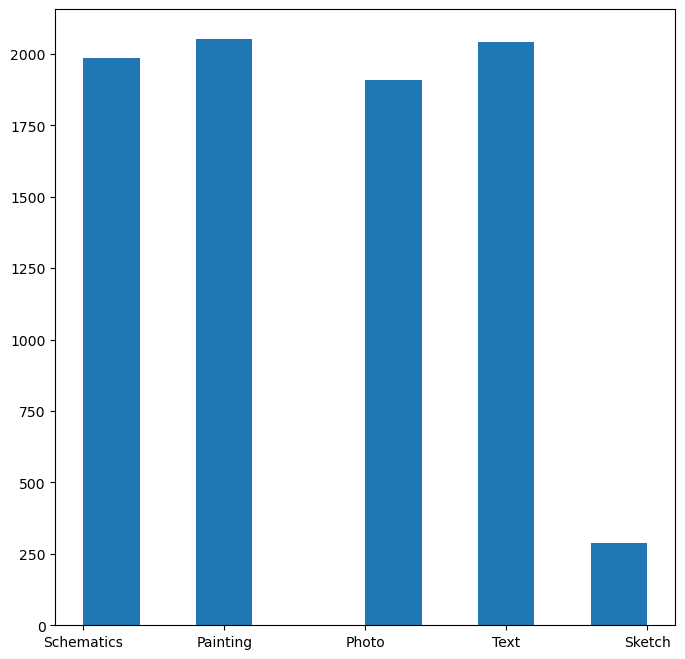

Nous voyons donc que les jeux de données ne sont pas équilibré, cela risquerait de donner un bies dans le model.
Pour cela nous verrons par la suite comment nous avons remedier à ce problème.


Par la suite nous avons aussi décider d'afficher différentes images de chaque classe, de façon à avoir une représentation de chaque classe.

1


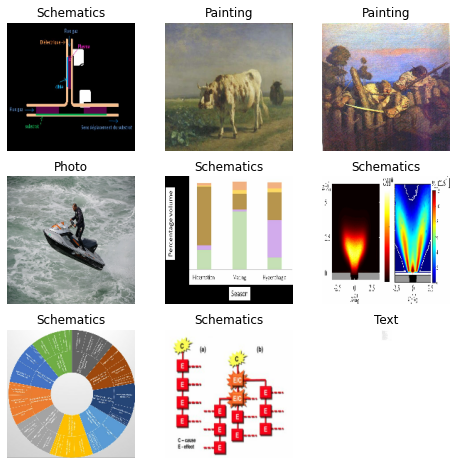

In [10]:
label_list = []
i=0
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(-1):
    i += 1
    print(i)
for label in labels.numpy():
    label_list.append(class_names[label])
for i in range(9):
    ax =  plt.subplot(3, 3, i + 1)
    plt.title(class_names[labels[i]])
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

plt.hist(label_list)
plt.show()


### Batch info

In [12]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8281, 180, 180, 3)
(8281,)


## Mise en cache

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

### Trier l'image en noir et blanc

In [14]:
def removeBlackAndWhite():
    for image in data_dir:
        with Image.open(image) as im:
            colors = im.getcolors()
        print(colors)
        # if que du noir, remove l'image



## Construction du modèle

In [6]:
num_classes = len(class_names)
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(image_h,
                                  image_w,
                                  3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
  ]
)

# Le modèle
model_with_data_augmentation = Sequential([ 
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(image_h, image_w, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
]) #A COMPLETER
# Compilation du modèle
model_with_data_augmentation.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# Résumé du modèle
model_with_data_augmentation.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [8]:
import os
# Prepare for model checkpoints
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
# Entrainement du modèle
epochs=10
history = model_with_data_augmentation.fit(
  train_set,
  validation_data=validation_set,
  epochs=epochs,
  callbacks=[cp_callback])
)

# Save the model
save_path = "checkpoints/"+now.strftime("%d-%m-%Y_%H-%M-%S")+".ckpt"
model.save_weights(save_path)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['recall']
val_loss = history.history['val_recall']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()